<a href="https://colab.research.google.com/github/raghadenawar23/12th-assignment-raghade-nawar-19101522.ipynb/blob/main/12th_assignment_raghade_nawar_19101522.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/training.csv', encoding='latin-1', header=None)
df.columns = ['target', 'id', 'date', 'query_flag', 'user', 'tweet_text']
df.head()

,target,id,date,query_flag,user,tweet_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
type(pd)

module

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

Load the dataframe

In [ ]:
X = df[['user','tweet_text']]
y = df['target']

In [ ]:
from sklearn.model_selection import train_test_split
X_train,  y_train = train_test_split(df, test_size=0.2, random_state=123)
X_validation, y_test= train_test_split(y_train, test_size=0.5, random_state=123)

print('Training Data Shape:', X_train.shape)
print('Validation Data Shape: ', X_validation.shape)
print('Testing Data Shape: ', y_test.shape)

Training Data Shape: (1280000, 6)
Validation Data Shape:  (160000, 6)
Testing Data Shape:  (160000, 6)


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train['tweet_text'].values,X_train['target'].values))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
test_dataset = tf.data.Dataset.from_tensor_slices((y_test['tweet_text'].values,y_test['target'].values))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


### Text Encoding

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode ="int",
    output_sequence_length=100)
encoder.adapt(X_train['tweet_text'].values)

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:30]

array(['', '[UNK]', 'i', 'to', 'the', 'a', 'my', 'and', 'you', 'is', 'it',
       'for', 'in', 'of', 'im', 'on', 'me', 'so', 'have', 'that', 'but',
       'just', 'with', 'be', 'at', 'its', 'not', 'was', 'this', 'now'],
      dtype='<U13')

### Build and Train The Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.summary() # n2+n+mn+kn+k

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 100, 64)           64000     
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 78,593
Trainable params: 78,593
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
20000/20000 [==============================] - 1866s 93ms/step - loss: -2239.8535 - accuracy: 0.0527 - val_loss: -6049.5166 - val_accuracy: 0.0635
Epoch 2/5
20000/20000 [==============================] - 1846s 92ms/step - loss: -13251.8701 - accuracy: 0.0697 - val_loss: -22029.9609 - val_accuracy: 0.0688
Epoch 3/5
20000/20000 [==============================] - 1825s 91ms/step - loss: -33768.0430 - accuracy: 0.0693 - val_loss: -49261.0977 - val_accuracy: 0.0667
Epoch 4/5
20000/20000 [==============================] - 1832s 92ms/step - loss: -65688.5703 - accuracy: 0.0775 - val_loss: -80842.7656 - val_accuracy: 0.1141
Epoch 5/5
20000/20000 [==============================] - 1832s 92ms/step - loss: -108114.9531 - accuracy: 0.1178 - val_loss: -131016.1562 - val_accuracy: 0.1161


### Prediction and Plotting

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2500/2500 [==============================] - 65s 26ms/step - loss: -132211.5781 - accuracy: 0.1213
Test Loss: -132211.578125
Test Accuracy: 0.12134374678134918


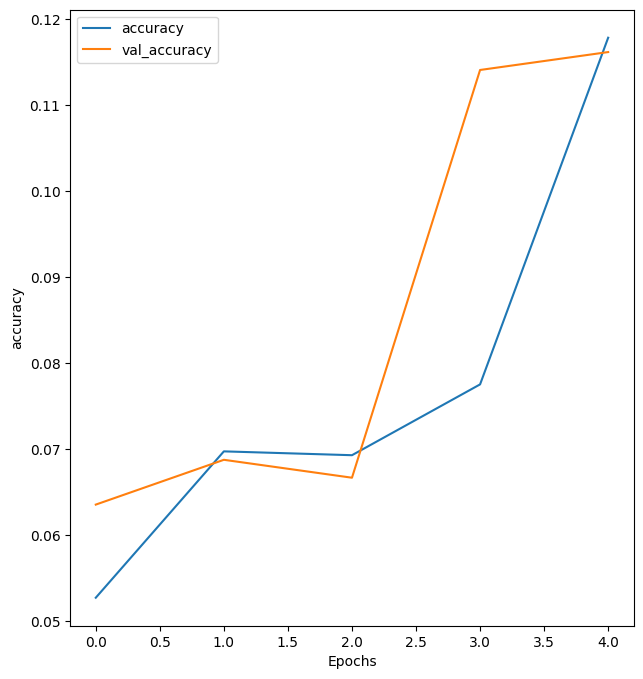

<ipython-input-22-bbddbdf6a590>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


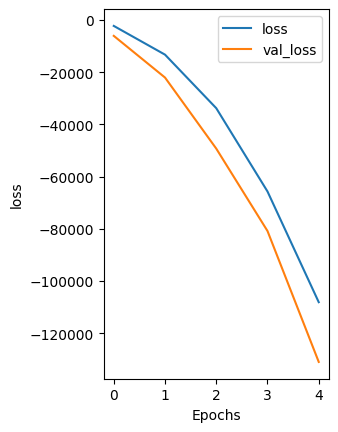

(0.0, 1.0)

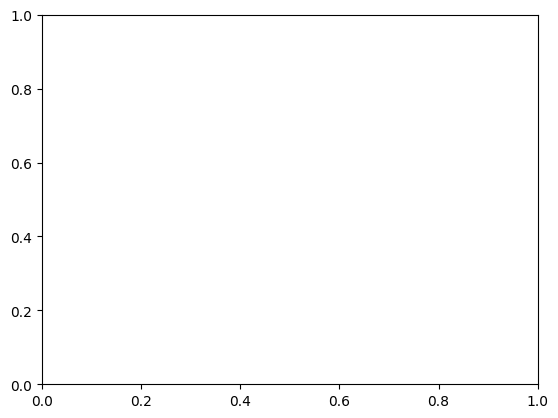

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)